## NeDF

In [338]:
# Import all the good stuff
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import numpy as np
import torch
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

### Utilitary functions

In [339]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)

In [340]:
def fov_to_focal_length(fov: float, width: int) -> float:
    """
    Convert field of view (FOV) to focal length.

    Args:
        fov (float): Field of view in degrees (horizontal).
        width (int): Image width in pixels.

    Returns:
        float: Focal length in pixels.
    """
    fov_tensor = torch.tensor(fov, dtype=torch.float32)
    focal_length = width / (2 * torch.tan(torch.deg2rad(fov_tensor / 2)))
    return focal_length

def pos_angle_to_tform_cam2world(camera_pos: torch.Tensor, camera_angle: torch.Tensor) -> torch.Tensor:
    """
    Create a transformation matrix from camera position and angles.

    Args:
        camera_pos (torch.Tensor): Camera position as (x, y, z).
        camera_angle (torch.Tensor): Camera angles as (pitch, yaw, roll) in degrees.

    Returns:
        torch.Tensor: 4x4 transformation matrix from camera to world.
    """
    pitch, yaw, roll = camera_angle

    # Define rotation matrices
    Rx = torch.tensor([
        [1, 0, 0],
        [0, torch.cos(pitch), -torch.sin(pitch)],
        [0, torch.sin(pitch), torch.cos(pitch)]
    ], dtype=torch.float32)

    Ry = torch.tensor([
        [torch.cos(yaw), 0, torch.sin(yaw)],
        [0, 1, 0],
        [-torch.sin(yaw), 0, torch.cos(yaw)]
    ], dtype=torch.float32)

    Rz = torch.tensor([
        [torch.cos(roll), -torch.sin(roll), 0],
        [torch.sin(roll), torch.cos(roll), 0],
        [0, 0, 1]
    ], dtype=torch.float32)

    # Combine rotation matrices
    rotation_matrix = Rz @ Ry @ Rx

    # Create a 4x4 transformation matrix
    tform_cam2world = torch.eye(4, dtype=torch.float32)
    tform_cam2world[:3, :3] = rotation_matrix
    tform_cam2world[:3, 3] = camera_pos

    return tform_cam2world

def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

### Network architecture

In [341]:
class VeryTinyNeDFModel(torch.nn.Module):
    r"""Define a "very tiny" NeDF model comprising three fully connected layers."""
    def __init__(self, filter_size=128, far_thresh=1000.0, L=10):
        self.L = L
        self.input_dim = 3 + 2 * L * 3 # Due to positional encoding
        # self.input_dim = 3 # Since we don't use it, just x,y,z
        super(VeryTinyNeDFModel, self).__init__()
        # Input layer (default: 3 + 2 * L * 3 -> 128 if positional encoding is enabled, 3 -> 128 otherwise)
        self.layer1 = torch.nn.Linear(self.input_dim, filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 1) for predicting distance
        self.layer3 = torch.nn.Linear(filter_size, 1)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu
        self.far_thresh = far_thresh

    # Not convincing currently
    def positional_encoding(self, x):
        encoded = [x]
        for i in range(self.L):
            encoded.append(torch.sin(2**i * x))
            encoded.append(torch.cos(2**i * x))
        return torch.cat(encoded, dim=-1)

    def forward(self, x):
        x = self.positional_encoding(x)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x) # Output is raw distance
        return torch.clamp(x, min=0.0, max=self.far_thresh) # Clamp output to prevent crazy / negative distances


### GPU vs CPU ?

In [342]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Load input images, poses, intrinsics, etc.

In [343]:
DATA_PATH = "./data/robot_orbital_bas"
CAMERAS_PATH = f"{DATA_PATH}/cameras_attributes.npz"
DEPTHS_PATH = f"{DATA_PATH}/depth"

FOV = 30.0
DEPTHMAP_SIZE_RESCALE = 100/1920
SCENE_SCALE = 1/1000

# BASE DATASET STRUCTURE
BASE_CAMERA_LOCATION_ENTRY = "cameras_locations"
BASE_CAMERA_ANGLE_ENTRY = "cameras_angle"

# TARGET DATASET STRUCTURE
RAYS_ENTRY = "rays"
RAY_ORIGINS_ENTRY = "ray_origins"
RAY_DIRECTIONS_ENTRY = "ray_directions"
DEPTH_MAP_ENTRY = "depth_map"
CAMERA_POS_ENTRY = "camera_pos"
CAMERA_ANGLE_ENTRY = "camera_angle"


In [344]:
# Load camera transforms
cameras = np.load(CAMERAS_PATH)

# Near and far clipping thresholds for depth values
near_thresh = 0.01
far_thresh = 500.0

# Initialize dataset
dataset = {}

print("Loading depth maps, generating rays, and sorting by depth...")
# Load depth maps
for filename in os.listdir(DEPTHS_PATH):
    # Extract the index from the filename
    index = re.search(r'\d+', filename)
    if index:
        index_value = int(index.group())

        # Ignore invalid entries
        angle_norm = np.linalg.norm(cameras[BASE_CAMERA_ANGLE_ENTRY][index_value])
        if angle_norm < 1 - 1e-6:
            print(f"- Skipping index {index_value} due to invalid angle norm: {angle_norm}")
            continue

        # Load the depth map
        depth_map_path = os.path.join(DEPTHS_PATH, filename)
        depth_map = cv2.imread(depth_map_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

        # Resize the depth map
        new_width = int(depth_map.shape[1] * DEPTHMAP_SIZE_RESCALE)
        new_height = int(depth_map.shape[0] * DEPTHMAP_SIZE_RESCALE)
        resized_depth_map = cv2.resize(depth_map, (new_width, new_height), interpolation=cv2.INTER_AREA)

        # Scale down the depth (too high for the current model)
        resized_depth_map = resized_depth_map * SCENE_SCALE

        # Compute focal length from FOV
        focal_length = fov_to_focal_length(FOV, new_width)

        # Convert position and angle to transformation matrix
        camera_pos = torch.tensor(cameras[BASE_CAMERA_LOCATION_ENTRY][index_value], dtype=torch.float32)
        camera_angle = torch.tensor(cameras[BASE_CAMERA_ANGLE_ENTRY][index_value], dtype=torch.float32)
        tform_cam2world = pos_angle_to_tform_cam2world(camera_pos, camera_angle)

        # Generate ray bundle
        ray_origins, ray_directions = get_ray_bundle(new_height, new_width, focal_length, tform_cam2world)

        # Store in the dataset
        dataset[index_value] = {
            RAYS_ENTRY: {
                RAY_ORIGINS_ENTRY: ray_origins,
                RAY_DIRECTIONS_ENTRY: ray_directions
            },
            DEPTH_MAP_ENTRY: resized_depth_map,
            CAMERA_POS_ENTRY: camera_pos,
            CAMERA_ANGLE_ENTRY: camera_angle
        }

# Manually remove invalid entries
DATASET_SIZE = len(dataset)
print(f"Successfully generated {DATASET_SIZE} entries!")


Loading depth maps, generating rays, and sorting by depth...
Successfully generated 16 entries!


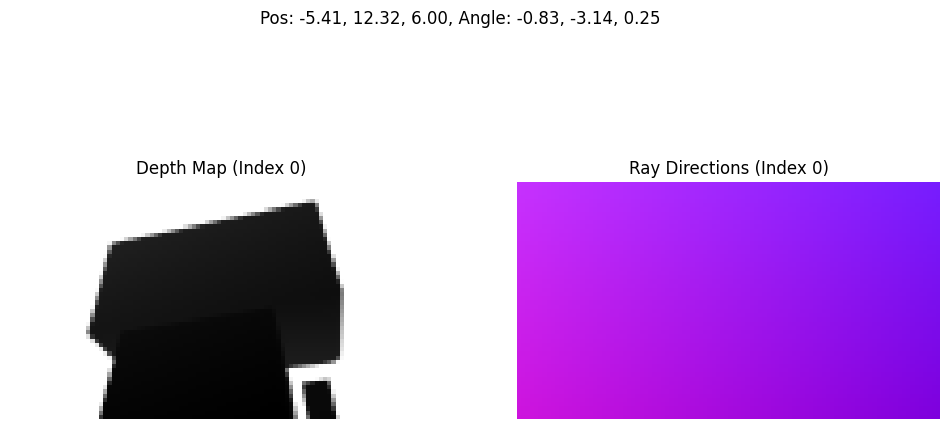

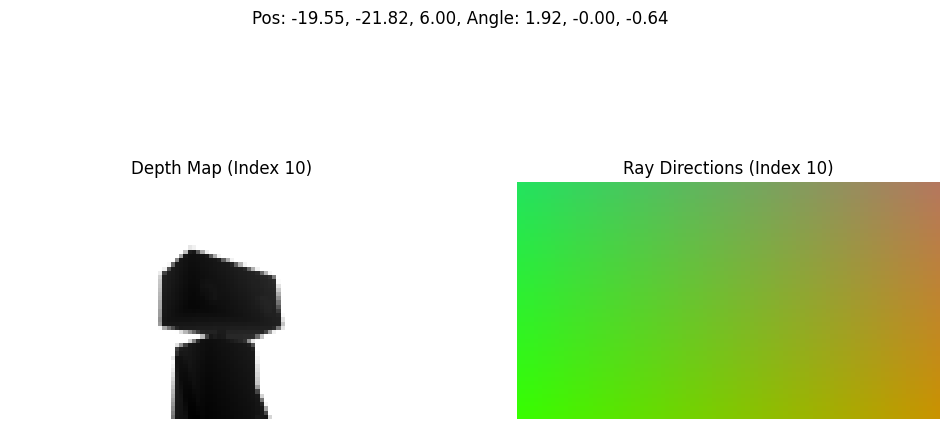

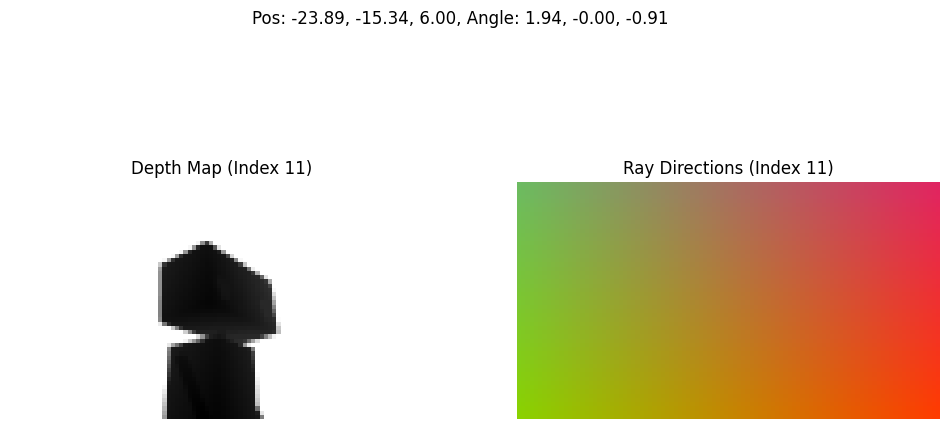

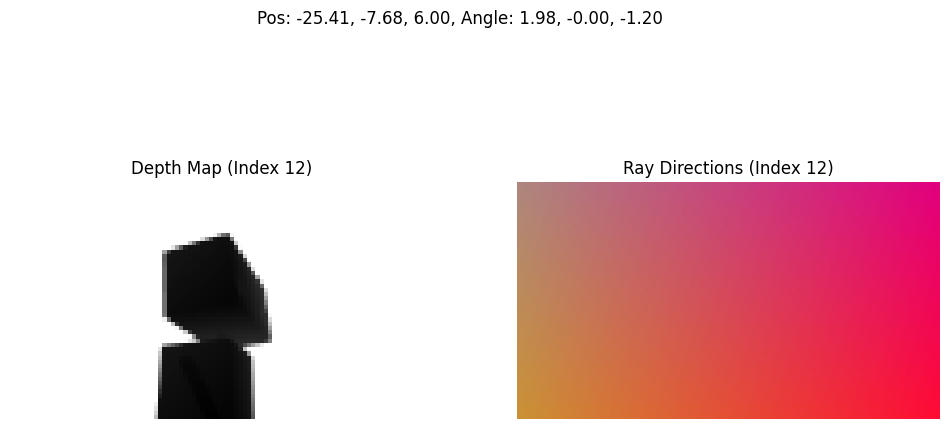

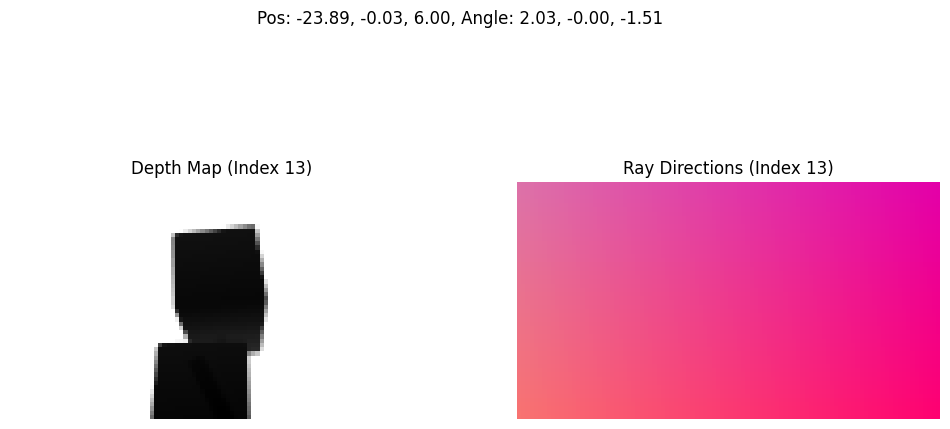

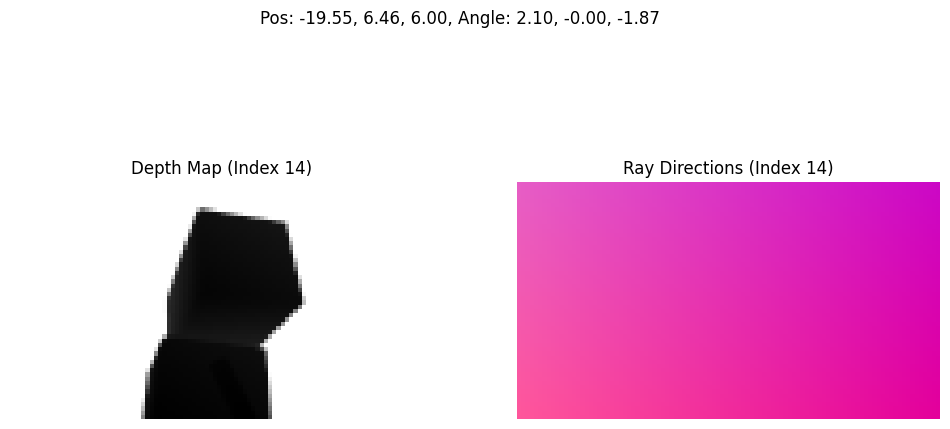

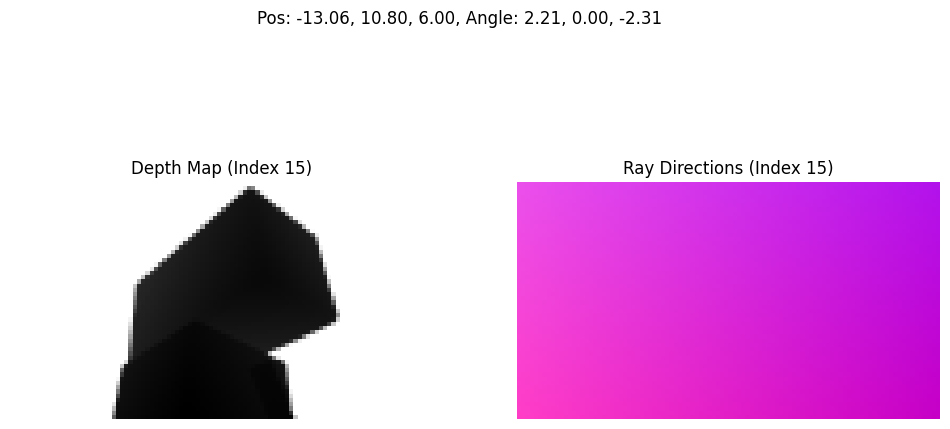

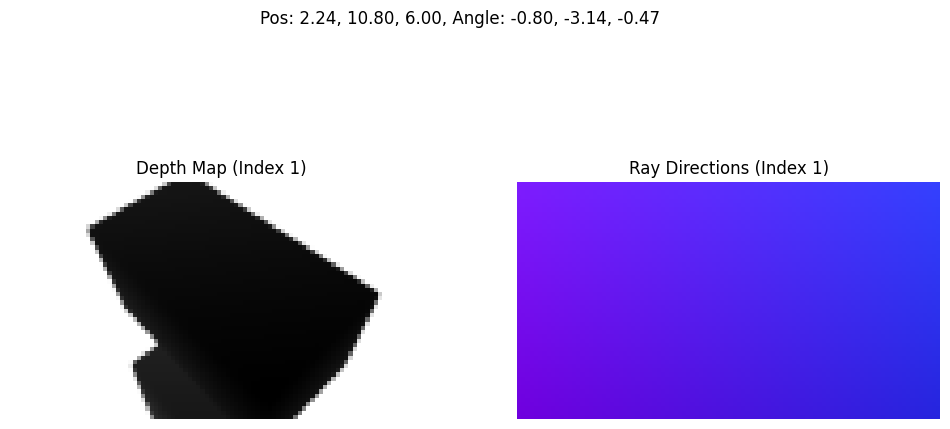

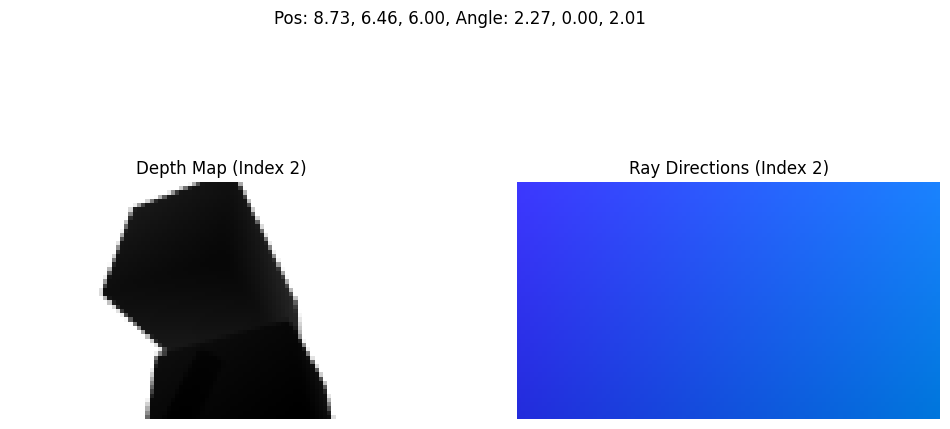

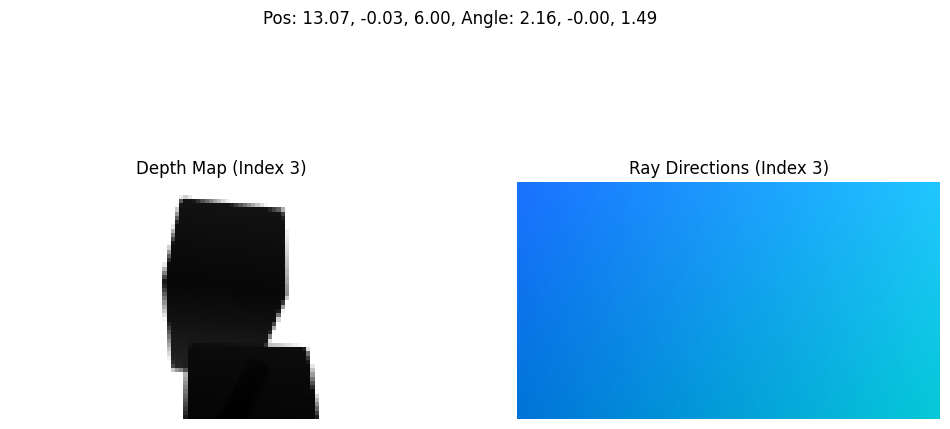

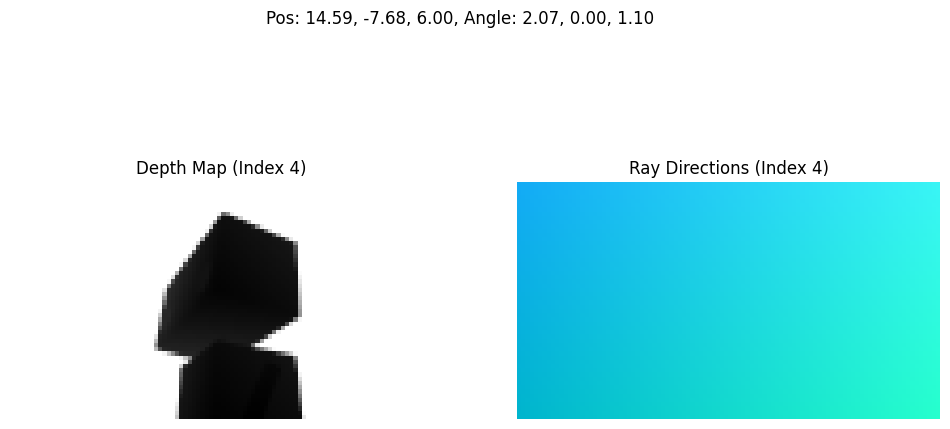

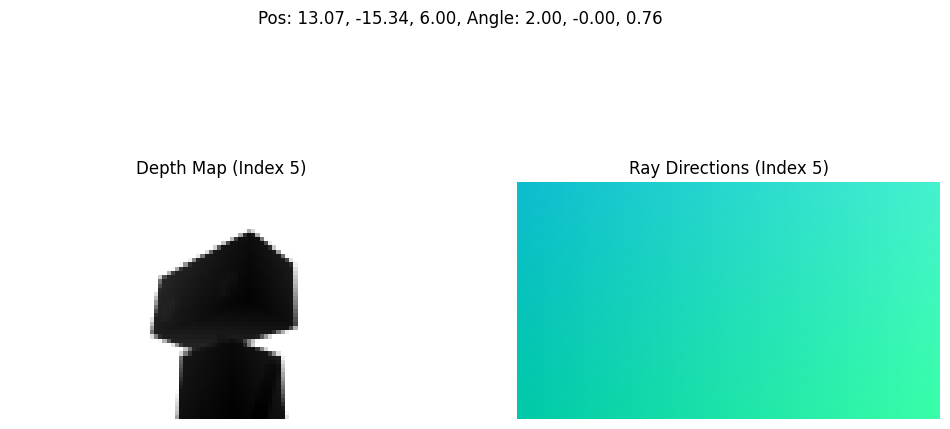

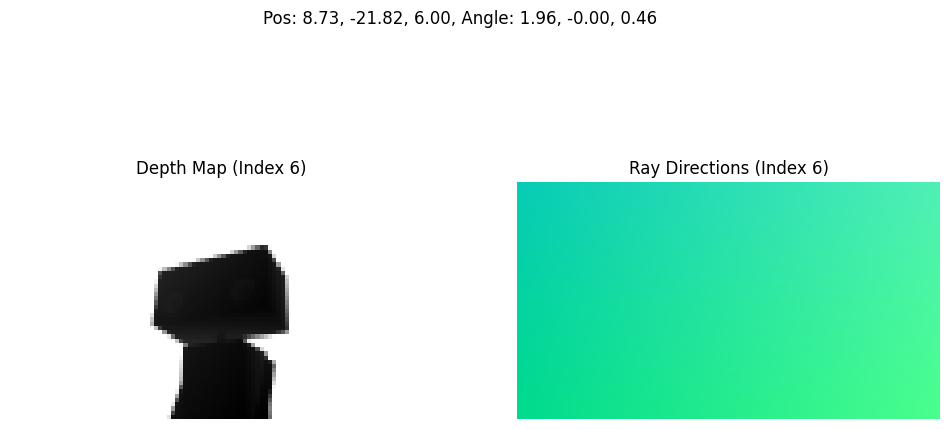

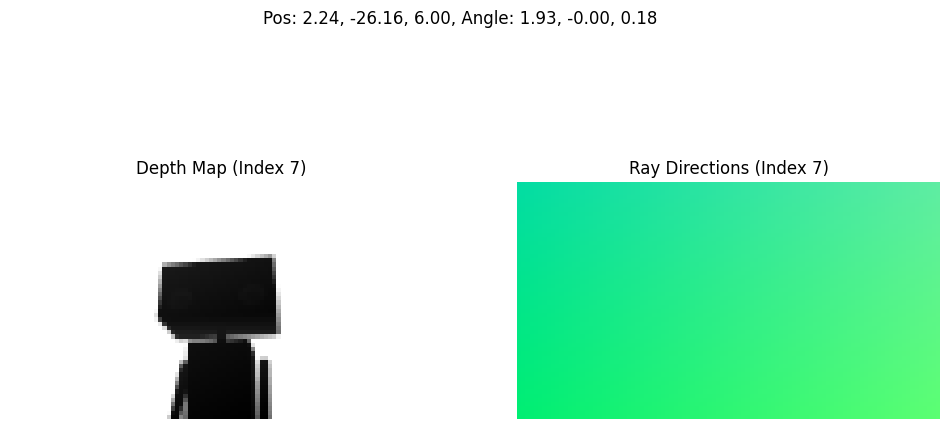

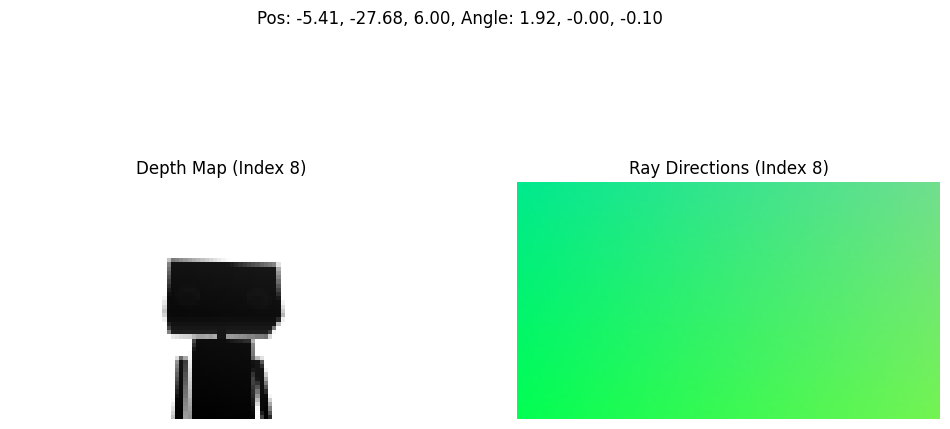

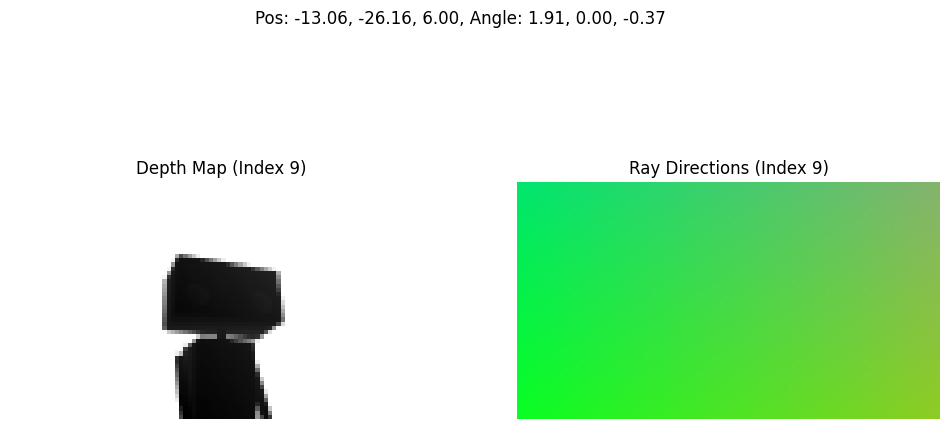

In [345]:
display_every = 1
for idx, data in dataset.items():
    if idx % display_every == 0:
        depth_image = data[DEPTH_MAP_ENTRY]
        ray_origins = data[RAYS_ENTRY][RAY_ORIGINS_ENTRY]
        ray_directions = data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY]
        camera_pos = data[CAMERA_POS_ENTRY]
        camera_angle = data[CAMERA_ANGLE_ENTRY]

        # Normalize rays for RGB visualization
        ray_rgb = (ray_directions - ray_directions.min()) / (ray_directions.max() - ray_directions.min())

        # Create a 2x1 plot
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Depth map
        axes[0].imshow(depth_image, cmap='gray')
        axes[0].set_title(f"Depth Map (Index {idx})")
        axes[0].axis('off')

        # Ray directions as RGB
        axes[1].imshow(ray_rgb.numpy())
        axes[1].set_title(f"Ray Directions (Index {idx})")
        axes[1].axis('off')

        # plt.suptitle(f"Camera Pos: {camera_pos}, Angle: {camera_angle}")
        # Format the camera angle to two decimal places
        formatted_angle = ', '.join([f"{angle:.2f}" for angle in camera_angle])
        formatted_pos = ', '.join([f"{pos:.2f}" for pos in camera_pos])

        # Update the plot title
        plt.suptitle(f"Pos: {formatted_pos}, Angle: {formatted_angle}")
        plt.show()

In [346]:
# Pre-pass function to sort depth and corresponding ray data
def sort_and_filter_depth_map(depth_map, ray_origins, ray_directions):
    # Flatten depth map and corresponding rays
    depth_flat = depth_map.flatten()
    ray_origins_flat = ray_origins.reshape(-1, 3)
    ray_directions_flat = ray_directions.reshape(-1, 3)

    # Validate shapes
    if len(depth_flat) != len(ray_origins_flat) or len(depth_flat) != len(ray_directions_flat):
        raise ValueError(f"Shape mismatch: depth {len(depth_flat)}, rays {len(ray_origins_flat)}")

    # Find maximum depth
    far_thresh = np.max(depth_flat)

    # Sort indices by depth
    sorted_indices = np.argsort(depth_flat)

    # Filter out max depth values
    valid_indices = sorted_indices[depth_flat[sorted_indices] < far_thresh]

    # Calculate and print the percentage of sorted-out values
    removed_percentage = 100 * (len(depth_flat) - len(valid_indices)) / len(depth_flat)
    print(f"Percentage of sorted-out values: {removed_percentage:.2f}%")

    # Apply sorting and filtering
    sorted_depth = depth_flat[valid_indices]
    sorted_ray_origins = ray_origins_flat[valid_indices]
    sorted_ray_directions = ray_directions_flat[valid_indices]

    return sorted_depth, sorted_ray_origins, sorted_ray_directions


# Post-process dataset to sort and filter depth maps
def post_process_dataset(dataset):
    print("Post-processing dataset...")

    for index, entry in dataset.items():
        try:
            # Extract depth map and ray data
            depth_map = entry[DEPTH_MAP_ENTRY]
            ray_origins = entry[RAYS_ENTRY][RAY_ORIGINS_ENTRY]
            ray_directions = entry[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY]

            # Apply sorting and filtering
            sorted_depth, sorted_ray_origins, sorted_ray_directions = sort_and_filter_depth_map(
                depth_map, ray_origins, ray_directions
            )

            # Update dataset entry
            dataset[index][DEPTH_MAP_ENTRY] = sorted_depth
            dataset[index][RAYS_ENTRY][RAY_ORIGINS_ENTRY] = sorted_ray_origins
            dataset[index][RAYS_ENTRY][RAY_DIRECTIONS_ENTRY] = sorted_ray_directions

        except Exception as e:
            print(f"Error processing index {index}: {e}")

    print("Post-processing complete!")
    return dataset


# Apply post-processing
dataset = post_process_dataset(dataset)

Post-processing dataset...
Percentage of sorted-out values: 53.43%
Percentage of sorted-out values: 83.48%
Percentage of sorted-out values: 83.02%
Percentage of sorted-out values: 82.66%
Percentage of sorted-out values: 81.68%
Percentage of sorted-out values: 75.00%
Percentage of sorted-out values: 63.77%
Percentage of sorted-out values: 52.62%
Percentage of sorted-out values: 62.07%
Percentage of sorted-out values: 72.73%
Percentage of sorted-out values: 76.07%
Percentage of sorted-out values: 78.88%
Percentage of sorted-out values: 81.36%
Percentage of sorted-out values: 82.88%
Percentage of sorted-out values: 83.77%
Percentage of sorted-out values: 83.98%
Post-processing complete!


### Train !

This method renders a depth map using the model's predictions to dynamically adjust step size during ray marching.

In [347]:
def render_depth_sphere_tracing(
    distance_field_model: torch.nn.Module,
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    depth_map: torch.Tensor,
    near_thresh: float,
    max_iterations: int = 50
) -> torch.Tensor:

    # Create a tensor to track active rays
    active_mask = torch.ones_like(depth_map, dtype=torch.bool)

    # Predicted depth map
    dstTravelled = torch.full_like(depth_map, 0, requires_grad=True)
    steps = torch.zeros_like(active_mask, dtype=torch.float32)
    
    all_query_points = []
    all_predicted_distances = []

    for i in range(max_iterations):
        # Stop if no active rays remain
        if not torch.any(active_mask):
            break
        
        # Compute the query points
        query_points = ray_origins + ray_directions * dstTravelled[..., None]
        query_points.requires_grad_()
        
        # Predict distances using the model
        predicted_distances = distance_field_model(query_points).squeeze(-1)

        # Increment the steps for active rays
        steps = torch.where(active_mask, steps + 1, steps)

        # Mask for rays that are within the surface threshold or exceeding far_thresh
        hit_mask = ((predicted_distances < near_thresh) | (dstTravelled >= depth_map)) & active_mask

        # Store active query points and predictions
        all_query_points.append(query_points[~hit_mask])
        all_predicted_distances.append(predicted_distances[~hit_mask])

        # Update active mask to deactivate rays that hit
        active_mask = active_mask & ~hit_mask
        
        # Update the depth map only for rays that have hit
        dstTravelled = torch.where(active_mask, dstTravelled + predicted_distances, dstTravelled)

    # Concatenate query points and distances
    all_query_points = torch.cat(all_query_points, dim=0)
    all_predicted_distances = torch.cat(all_predicted_distances, dim=0)

    return dstTravelled, steps, all_query_points, all_predicted_distances

In [348]:
def compute_gradients(model, query_points, eps=1e-4, sample_ratio=0.1):
    """
    Computes numerical gradients of SDF using finite differences.

    Args:
    - model: The implicit function.
    - query_points: Tensor of shape [N, 3], query points.
    - eps: Small step for finite differences.
    - sample_ratio: Fraction of points to sample for gradient computation.

    Returns:
    - gradients: Tensor of shape [sampled_N, 3], computed gradients.
    """
    N = query_points.shape[0]
    device = query_points.device

    # Randomly sample query points
    nb_samples = min(int(N * sample_ratio), 5000)
    sampled_indices = torch.randperm(N, device=device)[:nb_samples]
    sampled_points = query_points[sampled_indices]

    # Allocate memory for gradients
    gradients = torch.zeros_like(sampled_points, device=device)

    for i in range(3):  # Compute gradient w.r.t x, y, z
        offset = torch.zeros_like(sampled_points, device=device)
        offset[:, i] = eps

        forward_points = sampled_points + offset
        backward_points = sampled_points - offset

        forward_sdf = model(forward_points).squeeze(-1)
        backward_sdf = model(backward_points).squeeze(-1)

        # Central finite difference
        gradients[:, i] = (forward_sdf - backward_sdf) / (2 * eps)

    return gradients

def compute_eikonal_loss(gradients):
    """
    Computes the Eikonal loss using the computed gradients.

    Args:
    - gradients (torch.Tensor): Tensor of shape [N, 3] containing the gradients of SDF predictions.

    Returns:
    - loss (torch.Tensor): Computed Eikonal loss.
    """
    # ||grad|| should be close to 1, compute the deviation from 1
    loss = torch.mean(torch.abs(torch.norm(gradients, dim=-1) - 1))
    return loss

In [349]:
# Checkpoint saving function
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    # print(f"Checkpoint saved at {checkpoint_path}")

# Checkpoint loading function
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f"Loaded checkpoint from {checkpoint_path}: Epoch {epoch}, Loss: {loss:.4f}")
        return epoch, loss
    else:
        print(f"No checkpoint found at {checkpoint_path}")
        return 0, float('inf')

And now the training loop.

In [350]:
# # Conversion function
# def convert_old_to_new_format(data, near_thresh=0.01, far_thresh=500.0):
#     # Extract camera extrinsics, focal length, and depth map
#     testpose = torch.from_numpy(data["pose"]).float().to(device)
#     focal_length = torch.from_numpy(data["focal"]).float().to(device)
#     testimg = torch.from_numpy(data["depth_map"]).float().to(device)

#     # Height and width of the depth map
#     height, width = testimg.shape[:2]

#     # Generate ray bundle
#     ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, testpose)

#     # Package into the dataset format
#     new_data_format = {
#         0: {  # Use a dummy index 0 for a single item
#             RAYS_ENTRY: {
#                 RAY_ORIGINS_ENTRY: ray_origins,
#                 RAY_DIRECTIONS_ENTRY: ray_directions
#             },
#             DEPTH_MAP_ENTRY: testimg,
#             CAMERA_POS_ENTRY: testpose[:3, 3],  # Extract camera position from pose
#             CAMERA_ANGLE_ENTRY: testpose[:3, :3],  # Extract rotation matrix
#         }
#     }

#     print("Successfully converted old data format to new format.")
#     return new_data_format

# # Load the old data
# old_data = np.load("depth_map_test.npz")

# # Convert it to the new format
# converted_dataset = convert_old_to_new_format(old_data)

# # Use the converted data in the training pipeline
# test_dataset = converted_dataset
# DATASET_SIZE = len(test_dataset)
# print(f"Loaded dataset with {DATASET_SIZE} entries!")

# resized_depth_map = cv2.resize(
#     dataset[0][DEPTH_MAP_ENTRY], 
#     (100, 100),
#     interpolation=cv2.INTER_LINEAR
# )

# resized_ray_origins = cv2.resize(
#     dataset[0][RAYS_ENTRY][RAY_ORIGINS_ENTRY].clone().cpu().numpy(), 
#     (100, 100),
#     interpolation=cv2.INTER_LINEAR
# )

# resized_ray_directions = cv2.resize(
#     dataset[0][RAYS_ENTRY][RAY_DIRECTIONS_ENTRY].clone().cpu().numpy(), 
#     (100, 100),
#     interpolation=cv2.INTER_LINEAR
# )

# test_dataset[0][RAYS_ENTRY][RAY_DIRECTIONS_ENTRY] = torch.from_numpy(resized_ray_directions).to(device)
# test_dataset[0][RAYS_ENTRY][RAY_ORIGINS_ENTRY] = torch.from_numpy(resized_ray_origins).to(device)
# print(test_dataset[0][RAYS_ENTRY][RAY_ORIGINS_ENTRY][0, 0])
# test_dataset[0][DEPTH_MAP_ENTRY] = resized_depth_map

# # Plot the resized depth map
# plt.imshow(test_dataset[0][DEPTH_MAP_ENTRY], cmap='inferno')
# plt.colorbar()
# plt.title("New Depth Map (100x100)")
# plt.show()

# plt.imshow(test_dataset[0][RAYS_ENTRY][RAY_ORIGINS_ENTRY].cpu().numpy())
# plt.colorbar()
# plt.title("New origins Map (100x100)")
# plt.show()

# plt.imshow(test_dataset[0][RAYS_ENTRY][RAY_DIRECTIONS_ENTRY].cpu().numpy())
# plt.colorbar()
# plt.title("New directions Map (100x100)")
# plt.show()

In [357]:
import os
import torch
import random

# Training parameters
L = 5
lr = 1e-5
num_iters = 50000000
display_every = 10
save_every = 50  # Save every n iterations
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Model and optimizer
model = VeryTinyNeDFModel(L=L).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Seed RNG
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Hyperparameters
eikonal_penalty_weight = 2
batch_size = 1024*8  # Number of rays per batch

# Load previous checkpoint if available
start_epoch, best_loss = load_checkpoint(model, optimizer, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

# Training Loop (Random Ray Sampling Without Loop)
for i in range(start_epoch, num_iters):
    # Sample random dataset indices
    indices = torch.randint(0, len(dataset), (batch_size,))

    # Extract data for all sampled indices
    data_batch = [list(dataset.values())[idx] for idx in indices.cpu().numpy()]

    # Flatten ray and depth arrays for uniform sampling
    target_depth = torch.cat([torch.tensor(data[DEPTH_MAP_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)
    ray_origins = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_ORIGINS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)
    ray_directions = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)

    # Sample random pixel coordinates from the flattened array
    rand_coords = torch.randint(0, target_depth.shape[0], (batch_size,))

    # Gather samples
    sampled_depth = target_depth[rand_coords]
    sampled_ray_origins = ray_origins[rand_coords]
    sampled_ray_directions = ray_directions[rand_coords]

    # Ensure there are valid samples left after sampling
    if sampled_ray_origins.shape[0] == 0:
        print("No valid samples found, skipping this batch.")
        continue

    # Perform sphere tracing
    depth_predicted, steps, query_points, query_results = render_depth_sphere_tracing(
        model, sampled_ray_origins, sampled_ray_directions, sampled_depth, near_thresh
    )

    # Compute Loss
    gradients = compute_gradients(model, query_points)
    eikonal_loss = compute_eikonal_loss(gradients)
    depth_loss = torch.nn.functional.mse_loss(depth_predicted, sampled_depth)
    total_loss = depth_loss + eikonal_loss * eikonal_penalty_weight

    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display Progress
    if i % display_every == 0:
        print(f"\n### Step {i} ###")
        print(f"Average steps: {steps.mean().item():.2f}")
        print(f"Total loss: {total_loss.item():.2f} (Depth: {depth_loss.item():.2f}, Eikonal: {eikonal_loss.item():.2f})")
        print(f"Best loss: {best_loss:.2f}")

    # Save checkpoint periodically or if loss improves
    if i % save_every == 0 or total_loss.item() < best_loss:
        if total_loss.item() < best_loss:
            print("New best loss!")
            best_loss = total_loss.item()
        save_checkpoint(model, optimizer, i, total_loss.item(), os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

print("Training complete!")

Loaded checkpoint from checkpoints\latest_checkpoint.pth: Epoch 19054, Loss: 4.9552


C:\Users\Guest\AppData\Local\Temp\ipykernel_20548\2186305428.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_origins = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_ORIGINS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)
C:\Users\Guest\AppData\Local\Temp\ipykernel_20548\2186305428.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_directions = torch.cat([torch.tensor(data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32) for data in data_batch]).to(device)


New best loss!

### Step 19060 ###
Average steps: 28.57
Total loss: 5.25 (Depth: 4.71, Eikonal: 0.27)
Best loss: 4.82
New best loss!

### Step 19070 ###
Average steps: 28.52
Total loss: 5.45 (Depth: 4.90, Eikonal: 0.27)
Best loss: 4.78
New best loss!

### Step 19080 ###
Average steps: 28.45
Total loss: 5.04 (Depth: 4.50, Eikonal: 0.27)
Best loss: 4.11

### Step 19090 ###
Average steps: 28.62
Total loss: 5.27 (Depth: 4.72, Eikonal: 0.27)
Best loss: 4.11

### Step 19100 ###
Average steps: 28.61
Total loss: 5.30 (Depth: 4.76, Eikonal: 0.27)
Best loss: 4.11

### Step 19110 ###
Average steps: 28.49
Total loss: 4.60 (Depth: 4.06, Eikonal: 0.27)
Best loss: 4.11

### Step 19120 ###
Average steps: 28.20
Total loss: 4.79 (Depth: 4.26, Eikonal: 0.27)
Best loss: 4.11
New best loss!

### Step 19130 ###
Average steps: 27.95
Total loss: 4.28 (Depth: 3.74, Eikonal: 0.27)
Best loss: 3.75

### Step 19140 ###
Average steps: 27.92
Total loss: 4.60 (Depth: 4.05, Eikonal: 0.28)
Best loss: 3.75

### Step 191

KeyboardInterrupt: 

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to render a scene using the trained model
def render_scene(model, pos, direction, width, height, focal_length, near_thresh, device):
    model.eval()  # Set model to evaluation mode
    
    # Generate ray bundle from position and direction
    tform_cam2world = pos_angle_to_tform_cam2world(pos, direction)
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, tform_cam2world)

    # Perform sphere tracing
    with torch.no_grad():
        depth_predicted, steps, query_points, _ = render_depth_sphere_tracing(
            model, ray_origins.to(device), ray_directions.to(device), None, near_thresh
        )

    # Normalize and visualize
    depth_predicted_np = depth_predicted.cpu().numpy()
    depth_normalized = (depth_predicted_np - depth_predicted_np.min()) / (depth_predicted_np.max() - depth_predicted_np.min())

    # Plot the result
    plt.imshow(depth_normalized, cmap='inferno')
    plt.colorbar()
    plt.title("Rendered Scene - Depth Map")
    plt.show()

    print(f"Average Steps Taken: {steps.mean().item():.2f}")

# Example usage (replace with actual test camera pose and direction)
test_pos = torch.tensor([0, 0, -5], dtype=torch.float32).to(device)
test_dir = torch.tensor([0, 0, 1], dtype=torch.float32).to(device)
test_width, test_height = 100, 100  # Target rendering size
test_focal_length = 500.0  # Example focal length

# Render the scene after training
render_scene(
    model=model, 
    pos=test_pos, 
    direction=test_dir, 
    width=test_width, 
    height=test_height, 
    focal_length=test_focal_length, 
    near_thresh=near_thresh, 
    device=device
)

TypeError: ones_like(): argument 'input' (position 1) must be Tensor, not NoneType

In [ ]:
import os
import torch
import random

# Training parameters
L = 5
lr = 1e-4
num_iters = 500000
display_every = 10
save_every = 50  # Save every n iterations
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Model and optimizer
model = VeryTinyNeDFModel(L=L).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Seed RNG
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Hyperparameters
eikonal_penalty_weight = 5
batch_size = 1024  # Number of rays per batch

# Load previous checkpoint if available
# start_epoch, best_loss = load_checkpoint(model, optimizer, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))
start_epoch = 0
best_loss = 1e10

# Training Loop (Random Ray Sampling Without Loop)
for i in range(start_epoch, num_iters):
    # Extract data for all sampled indices
    data = list(test_dataset.values())[0]


    # Gather depths to filter out pixels with depth < 50

    target_depth = torch.tensor(data[DEPTH_MAP_ENTRY], dtype=torch.float32).to(device)
    # Add batch and channel dimensions for interpolation

    min_depth = target_depth.min().item()
    max_depth = target_depth.max().item()
    avg_depth = target_depth.mean().item()

    # print(f"min depth: {min_depth}")
    # print(f"max depth: {max_depth}")
    # print(f"avg depth: {avg_depth}")

    # Filter data using the mask
    ray_origins = torch.tensor(data[RAYS_ENTRY][RAY_ORIGINS_ENTRY], dtype=torch.float32).to(device)
    ray_directions = torch.tensor(data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32).to(device)

    # Perform sphere tracing
    depth_predicted, steps, query_points, query_results = render_depth_sphere_tracing(
        model, ray_origins, ray_directions, target_depth, near_thresh
    )

    # Compute Loss
    gradients = compute_gradients(model, query_points)
    eikonal_loss = compute_eikonal_loss(gradients)
    depth_loss = torch.nn.functional.mse_loss(depth_predicted, target_depth)
    total_loss = depth_loss + eikonal_loss * eikonal_penalty_weight

    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display Progress
    if i % display_every == 0:
        print(f"\n### Step {i}: ###")
        print(f"Average steps: {steps.mean().item():.2f}")
        print(f"Total Loss: {total_loss.item():.4f}")
        print(f"Depth Loss: {depth_loss.item():.4f}")
        print(f"Eikonal Loss: {eikonal_loss.item():.4f}")

    # Save checkpoint periodically or if loss improves
    # if i % save_every == 0 or total_loss.item() < best_loss:
    #     best_loss = total_loss.item()
    #     save_checkpoint(model, optimizer, i, total_loss.item(), os.path.join(checkpoint_dir, "latest_checkpoint.pth"))

print("Training complete!")
